In [1]:
# !pip install kmodes

In [2]:
# import key libraries
import pyreadstat
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk

# other libraries
import missingno as msno
from math import ceil
from regressors import stats
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load SAS file
og_df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

In [4]:
df = og_df.copy()

# **Dataset exploration**

In [5]:
# data types
df.dtypes

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [6]:
# data description
df.describe(include = "all").T

count unique          top  freq         mean          std  \
CustID         10296.0    NaN          NaN   NaN       5148.5   2972.34352   
FirstPolYear   10266.0    NaN          NaN   NaN  1991.062634   511.267913   
BirthYear      10279.0    NaN          NaN   NaN  1968.007783    19.709476   
EducDeg          10296      5  3 - BSc/MSc  4799          NaN          NaN   
MonthSal       10260.0    NaN          NaN   NaN  2506.667057  1157.449634   
GeoLivArea     10295.0    NaN          NaN   NaN     2.709859     1.266291   
Children       10275.0    NaN          NaN   NaN     0.706764     0.455268   
CustMonVal     10296.0    NaN          NaN   NaN   177.892605  1945.811505   
ClaimsRate     10296.0    NaN          NaN   NaN     0.742772     2.916964   
PremMotor      10262.0    NaN          NaN   NaN   300.470252   211.914997   
PremHousehold  10296.0    NaN          NaN   NaN   210.431192   352.595984   
PremHealth     10253.0    NaN          NaN   NaN   171.580833   296.405976   
PremLife       10192.0    NaN          NaN   NaN    41.855782    47.480632   
PremWork       10210.0    NaN          NaN   NaN    41.277514    51.513572   

                     min      25%     50%       75%       max  
CustID               1.0  2574.75  5148.5   7722.25   10296.0  
FirstPolYear      1974.0   1980.0  1986.0    1992.0   53784.0  
BirthYear         1028.0   1953.0  1968.0    1983.0    2001.0  
EducDeg              NaN      NaN     NaN       NaN       NaN  
MonthSal           333.0   1706.0  2501.5   3290.25   55215.0  
GeoLivArea           1.0      1.0     3.0       4.0       4.0  
Children             0.0      0.0     1.0       1.0       1.0  
CustMonVal    -165680.42    -9.44  186.87  399.7775  11875.89  
ClaimsRate           0.0     0.39    0.72      0.98     256.2  
PremMotor          -4.11   190.59  298.61     408.3  11604.42  
PremHousehold      -75.0    49.45   132.8    290.05   25048.8  
PremHealth         -2.11    111.8  162.81    219.82   28272.0  
PremLife            -7.0     9.89   25.56     57.79     398.3  
PremWork           -12.0    10.67   25.67     56.79    1988.7

In [7]:
# take a look at the data
df.head(10)

CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  2 - High School    2177.0         1.0   
1     2.0        1981.0     1995.0  2 - High School     677.0         4.0   
2     3.0        1991.0     1970.0        1 - Basic    2277.0         3.0   
3     4.0        1990.0     1981.0      3 - BSc/MSc    1099.0         4.0   
4     5.0        1986.0     1973.0      3 - BSc/MSc    1763.0         4.0   
5     6.0        1986.0     1956.0  2 - High School    2566.0         4.0   
6     7.0        1979.0     1943.0  2 - High School    4103.0         4.0   
7     8.0        1988.0     1974.0  2 - High School    1743.0         4.0   
8     9.0        1981.0     1978.0      3 - BSc/MSc    1862.0         1.0   
9    10.0        1976.0     1948.0      3 - BSc/MSc    3842.0         1.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   
5       1.0      -24.33        1.00     440.75          18.90      114.80   
6       0.0      -66.01        1.05     156.92         295.60      317.95   
7       1.0     -144.91        1.13     248.27         397.30      144.36   
8       1.0      356.53        0.36     344.51          18.35      210.04   
9       0.0     -119.35        1.12     209.26         182.25      271.94   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45  
5      7.00      7.67  
6     14.67     26.34  
7     66.68     53.23  
8      8.78      9.89  
9     39.23     55.12

In [8]:
# set customer ID as index
df.CustID = df.CustID.astype("int")
df.set_index("CustID", inplace=True)

In [9]:
# check data types
df.dtypes

FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [10]:
# check for duplicated observations
print("Number of duplicate observations:", df.duplicated().sum())

# remove duplicate observations
df.drop_duplicates(inplace = True)
print("Removing duplicates...")
print("Number of duplicate observations:", df.duplicated().sum())

Number of duplicate observations: 3
Removing duplicates...
Number of duplicate observations: 0


In [11]:
# starting number of observations after duplicate removal
print(len(df))

10293


# **Cleaning up the dataset**

## Changing data types

In [12]:
# changing data types
# extract only number from EducDeg and save as float (ordinal variable)
# empty strings converted to NaN
# could also use sklearn's LabelEncoder??????????
df.EducDeg = df.EducDeg.str.extract("(\d+)")
# EducDeg is actually ordinal but stored as categorical for now
df.EducDeg = df.EducDeg.astype("category")

# convert other features to categorical
df.GeoLivArea = df.GeoLivArea.astype("category")
df.Children = df.Children.astype("category")

# check if changes were successful
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10293 entries, 1 to 10296
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FirstPolYear   10263 non-null  float64 
 1   BirthYear      10276 non-null  float64 
 2   EducDeg        10276 non-null  category
 3   MonthSal       10257 non-null  float64 
 4   GeoLivArea     10292 non-null  category
 5   Children       10272 non-null  category
 6   CustMonVal     10293 non-null  float64 
 7   ClaimsRate     10293 non-null  float64 
 8   PremMotor      10259 non-null  float64 
 9   PremHousehold  10293 non-null  float64 
 10  PremHealth     10250 non-null  float64 
 11  PremLife       10189 non-null  float64 
 12  PremWork       10207 non-null  float64 
dtypes: category(3), float64(10)
memory usage: 915.2 KB


## Cross-field validation

In [13]:
# 1997 rows where birth year is after the first policy year
df[df.BirthYear > df.FirstPolYear]

# high number of inconsistencies indicates systematic error
# assumption: people introduce the years in the wrong fields and many FirstPolYear and BirthYear are swapped
# swap FirstPolYear and BirthYear values when birth is after first policy creation
row_selector = df.BirthYear > df.FirstPolYear
df.loc[row_selector, ["FirstPolYear", "BirthYear"]] = df.loc[row_selector, ["BirthYear", "FirstPolYear"]].values

## Dealing with outliers

In [14]:
# define metric and non-metric features
metric_features = df.select_dtypes(include = np.number).columns.tolist()
non_metric_features = df.columns.drop(metric_features).tolist()

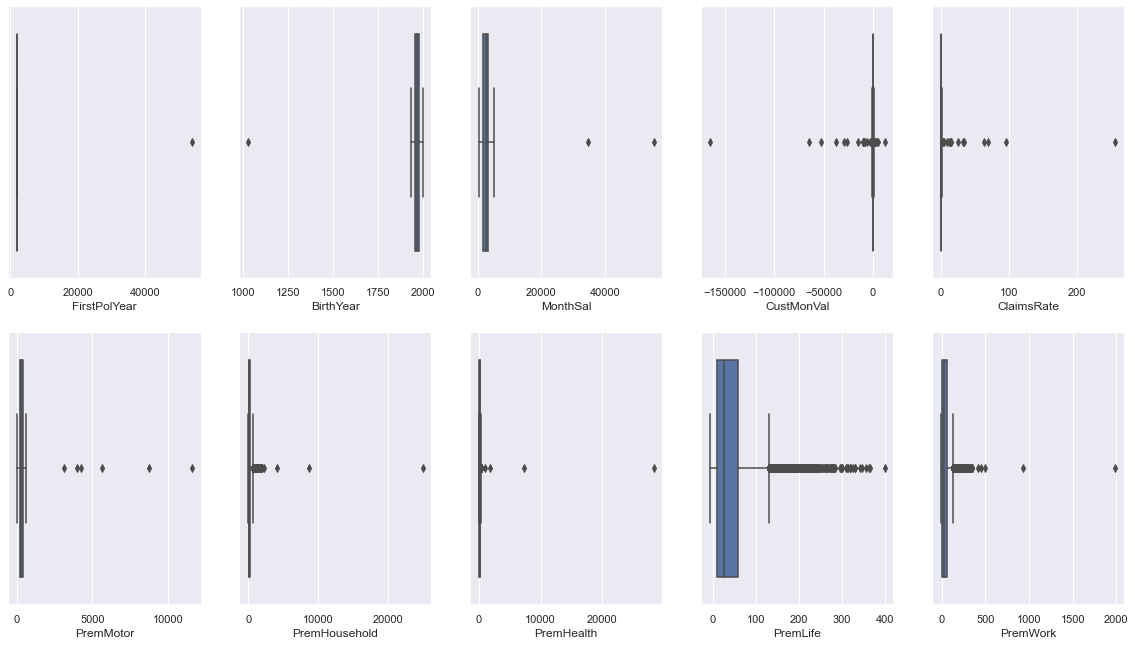

In [15]:
# boxplot of numeric variables to detect outliers
sns.set()

fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# iterate through axes objects and associate each box plot
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax)
    
plt.show()

In [16]:
# assume that 1028 in BirthYear is a typo and in reality corresponds to 1928
# 0 and 9 are fairly close in a qwerty keyboard
df.loc[df.BirthYear == 1028, "BirthYear"] = 1928

# store outliers in a separate dataframe (to be assigned to a cluster in the end)
# remove outliers from main dataframe, df
len_df = len(df)
filters = ((df.FirstPolYear.ge(2017)),
           (df.MonthSal.ge(20000)),
           (df.CustMonVal.le(-2000)),
           (df.CustMonVal.ge(1500)),
           (df.ClaimsRate.ge(4)),
           (df.PremMotor.ge(3000)),
           (df.PremHousehold.ge(1600)),
           (df.PremHealth.ge(5000)),
           (df.PremWork.ge(300)))
df_outliers = pd.DataFrame()

for filter_ in filters:
    df_outliers = df_outliers.append(df[filter_])
    df = df[~filter_]

# compute number of outliers removed
n_outliers = len(df_outliers)
perc_removed = round(n_outliers/len_df*100, 2)
print(f"Number of outliers removed: {n_outliers} ({perc_removed}% of all observations)")

Number of outliers removed: 55 (0.53% of all observations)


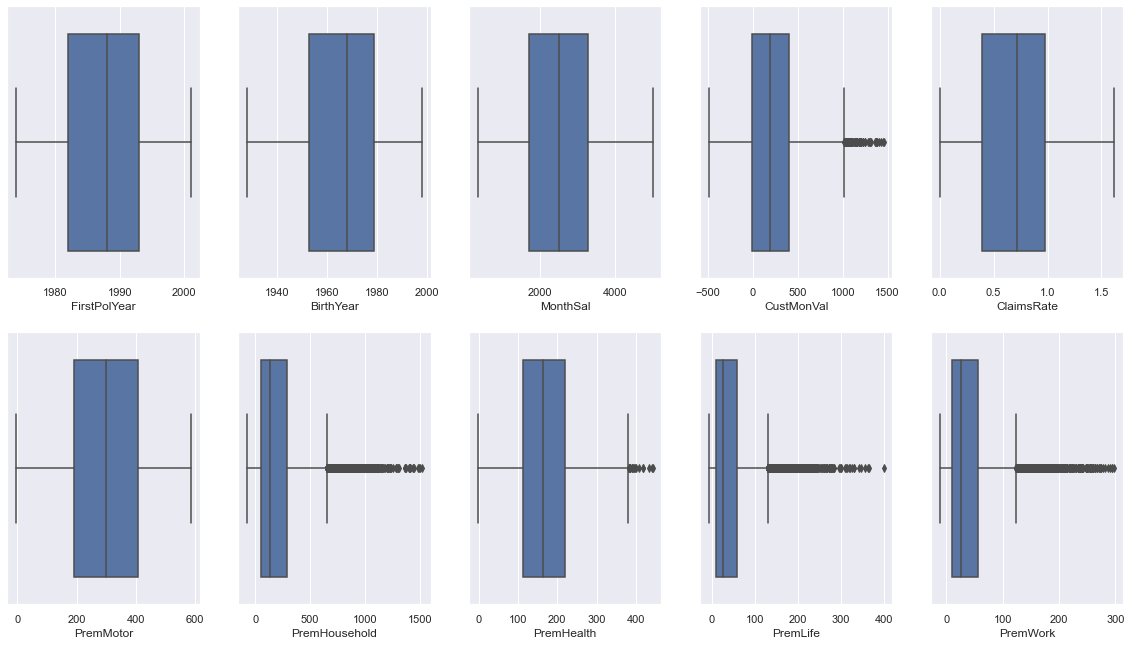

In [17]:
# boxplots of numeric variables after removing outliers
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax)
    
plt.show()

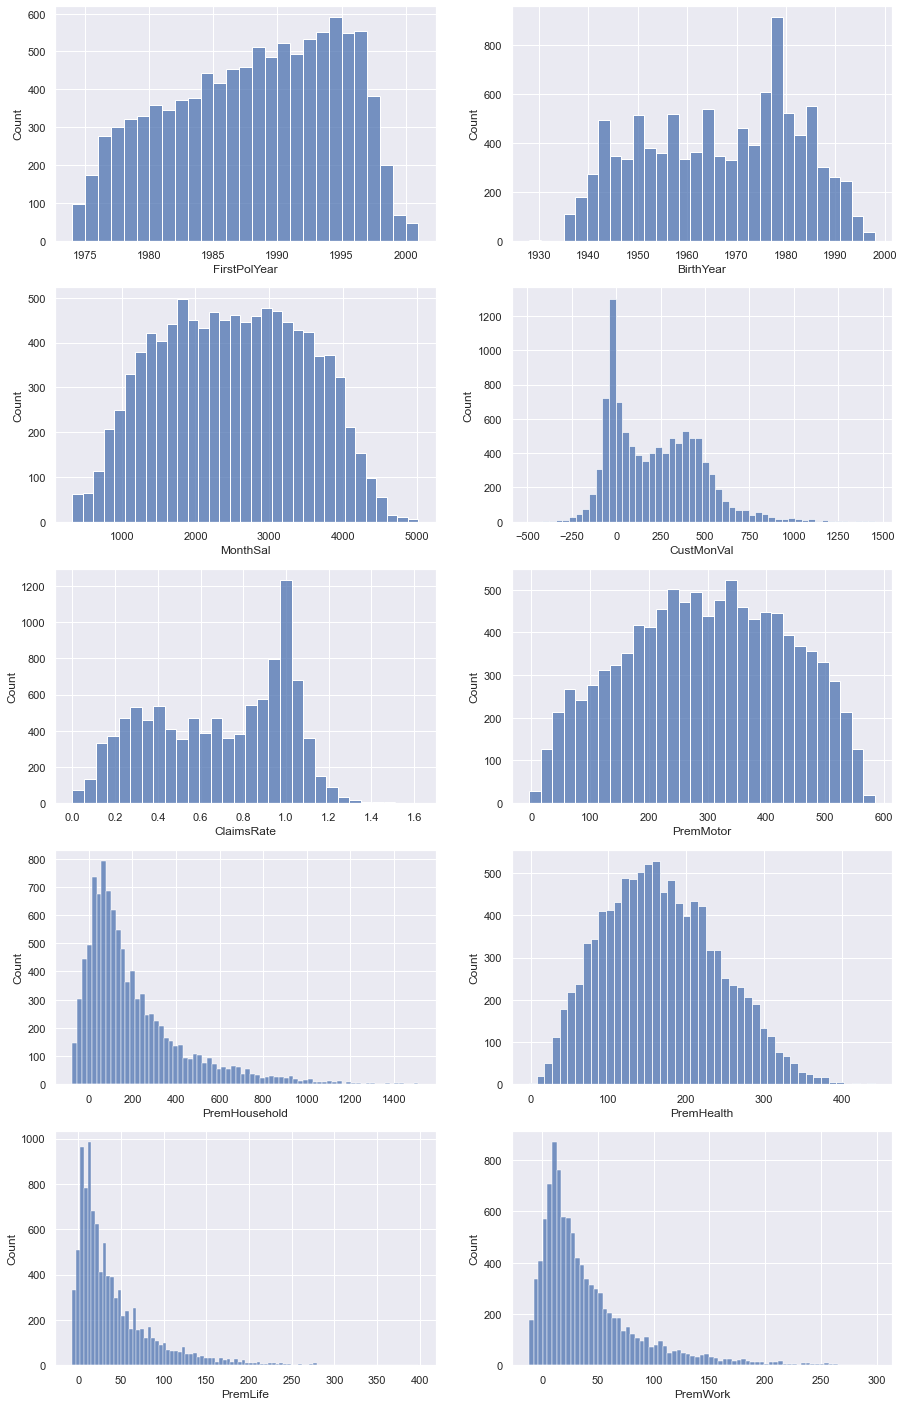

In [18]:
# CustMonVal, PremHousehold, PremHealth, PremLife, PremWork may require further processing
# histograms

sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(5, 2, figsize=(15, 25))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features):
    sns.histplot(x=df[feat], ax=ax)
    
plt.show()

# maybe deal with skewness here ??????????

In [19]:
# new look at the data after removing outliers
df.describe(include="all").T

count unique  top    freq         mean         std     min  \
FirstPolYear   10208.0    NaN  NaN     NaN  1987.629604    6.540021  1974.0   
BirthYear      10221.0    NaN  NaN     NaN   1966.42491   15.468052  1928.0   
EducDeg          10221      4    3    4782          NaN         NaN     NaN   
MonthSal       10202.0    NaN  NaN     NaN  2501.489316  982.555692   333.0   
GeoLivArea     10237.0    4.0  4.0  4120.0          NaN         NaN     NaN   
Children       10217.0    2.0  1.0  7222.0          NaN         NaN     NaN   
CustMonVal     10238.0    NaN  NaN     NaN    217.14454  254.723434  -490.2   
ClaimsRate     10238.0    NaN  NaN     NaN     0.680096    0.318477     0.0   
PremMotor      10205.0    NaN  NaN     NaN   297.623278  137.655141   -4.11   
PremHousehold  10238.0    NaN  NaN     NaN   205.072998  230.564861   -75.0   
PremHealth     10196.0    NaN  NaN     NaN   168.115505   74.095068   -2.11   
PremLife       10135.0    NaN  NaN     NaN     41.81805   47.492666    -7.0   
PremWork       10152.0    NaN  NaN     NaN     40.49038   45.289665   -12.0   

                  25%     50%       75%      max  
FirstPolYear   1982.0  1988.0    1993.0   2001.0  
BirthYear      1953.0  1968.0    1979.0   1998.0  
EducDeg           NaN     NaN       NaN      NaN  
MonthSal       1711.0  2504.0    3291.0   5021.0  
GeoLivArea        NaN     NaN       NaN      NaN  
Children          NaN     NaN       NaN      NaN  
CustMonVal    -9.1925  187.04  398.8675  1455.94  
ClaimsRate       0.39    0.72      0.98     1.62  
PremMotor      191.48  299.28     408.3   585.22  
PremHousehold   49.45   132.8     289.5  1513.05  
PremHealth     111.91  162.92    219.82   442.86  
PremLife         9.89   25.56     57.79    398.3  
PremWork        10.67   25.67     56.01    298.5

Dealing with missing values.

In [20]:
# checking feature completeness
nan_byfeature = df.isna().sum()
nan_pc_byfeature = df.isna().mean()*100
feature_nans = pd.concat([nan_byfeature, nan_pc_byfeature], axis=1)
feature_nans.rename(columns = {0: 'nr', 1: '%'}, inplace=True)
print('Missing values per feature:\n', feature_nans)

# checking max number of missing values per row
row_nan_count = []
for row in range(len(df)):
    row_nan_count.append(df.iloc[row].isna().sum())
print('\nMax NaN per row:', np.max(row_nan_count))

# not enough missing values in a single feature to merit excluding that feature
# not enough missing values in a single row to merit excluding those observations

Missing values per feature:
                 nr         %
FirstPolYear    30  0.293026
BirthYear       17  0.166048
EducDeg         17  0.166048
MonthSal        36  0.351631
GeoLivArea       1  0.009768
Children        21  0.205118
CustMonVal       0  0.000000
ClaimsRate       0  0.000000
PremMotor       33  0.322329
PremHousehold    0  0.000000
PremHealth      42  0.410236
PremLife       103  1.006056
PremWork        86  0.840008

Max NaN per row: 4


In [21]:
# remove rows with missing FirstPolYear and missing BirthYear
# removes a total of 44 rows
df = df[~df.FirstPolYear.isna()]
df = df[~df.BirthYear.isna()]

# remove rows with missing EducDeg
# removes 2 rows (only 2 NaN remaining after removing NaNs in year columns)
df = df[~df.EducDeg.isna()]

# replace NaN in Premiums with 0
# assumes no info about Premiums means no premium is paid
df.PremMotor.fillna(0, inplace=True)
df.PremHealth.fillna(0, inplace=True)
df.PremLife.fillna(0, inplace=True)
df.PremWork.fillna(0, inplace=True)

# replace missing MonthSal values with mean salary
# df.MonthSal.fillna(df.MonthSal.mean(), inplace=True)

In [22]:
# create a linear regression model to impute missing MonthSal values
# use all features but the MonthSal to train the model

# define independent and dependent variables
#X = df.dropna().drop(["MonthSal"], axis = 1)
#y = df.dropna().MonthSal

# split train and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# scale train and test data
#scaler = MinMaxScaler().fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# create and fit model
#lin_model = LinearRegression()
#lin_model.fit(X_train_scaled, y_train)

# predict y
#y_pred = lin_model.predict(X_test_scaled)

# evaluate the predictions of the linear reg model
#xlabels = X_train.columns
#stats.summary(clf = lin_model, X = X_train_scaled, y = y_train, xlabels = xlabels)
#mse = mean_squared_error(y_test, y_pred)
#rmse = mean_squared_error(y_test, y_pred, squared = False)
#mae = mean_absolute_error(y_test, y_pred)

# mse 171348
#print(mse)
# rmse 414
#print(rmse)
# mae 330
#print(mae)

In [23]:
# create a linear regression model to impute missing MonthSal values
# use only Age to train the model (found to have 0.9 correlation with MonthSal)
# justify this in the report: single linear regression seemed better suited than a multiple linear regression
# 1: explains almost all of the variance
# 2: produces only slightly bigger errors
# 3: other OLS algebraic properties or whatnot ???

# define independent and dependent variables
X = df.dropna().BirthYear
y = df.dropna().MonthSal

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
X_train = np.array(X_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)

# scale train and test data
#scaler = MinMaxScaler().fit(np.array(X_train).reshape(-1,1))
#X_train_scaled = scaler.transform(np.array(X_train).reshape(-1,1))
#X_test_scaled = scaler.transform(np.array(X_test).reshape(-1,1))

# create and fit model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# predict y
y_pred = lin_model.predict(X_test)

# evaluate the predictions of the linear reg model
#xlabels = "CustID"
stats.summary(clf = lin_model, X = X_train, y = y_train)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
mae = mean_absolute_error(y_test, y_pred)

# mse 178876
print(mse)
# rmse 423
print(rmse)
# mae 333
print(mae)

Residuals:
       Min        1Q   Median       3Q       Max
-1513.5206 -290.4269 -13.2861 268.4494 1734.4503


Coefficients:
                 Estimate  Std. Error     t value  p value
_intercept  115568.866430  633.534103    182.4193      0.0
x1             -57.498184    0.002689 -21381.9972      0.0
---
R-squared:  0.81769,    Adjusted R-squared:  0.81767
F-statistic: 31845.02 on 1 features
178875.80928702894
422.93712214350364
333.3451015075628


In [24]:
# model shows that increasing BirthYear by 1 (being 1 year younger) is expected to decrease monthly salary by 57.50€
# do we need to formally reject H0: beta1hat = 0 ?

In [25]:
# predict MonthSal NaN values
X_test = np.array(df[df.MonthSal.isna()].BirthYear).reshape(-1,1)
y_pred = lin_model.predict(X_test)

# impute values to MonthSal NaN
df.loc[df.MonthSal.isna(), "MonthSal"] = y_pred

In [26]:
# create a logistic regression model to impute missing Children values
# split df into data and target
data = df.dropna().drop(["Children", "GeoLivArea"], axis = 1)
target = df.dropna().Children

# split data into train (70%) and test (30%) datasets
# 70% have children, 30% dont, might need stratify = target
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=5, stratify = target)

# scale features using MinMaxScaler() with parameters from X_train
scaler = MinMaxScaler().fit(X_train)
# scale the training set
X_train_scaled = scaler.transform(X_train)
# scale the test set
X_test_scaled = scaler.transform(X_test)

# create a logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

# predict y
y_pred = log_model.predict(X_test_scaled)

# evaluate the predictions of the logistic reg model
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)
f1 = round(f1_score(y_test, y_pred)*100, 2)

print("Confusion matrix:\n", conf_matrix)
print("Accuracy:", accuracy, "%")
print("Precision:", precision, "%")
print("Recall:", recall, "%")
print("F1 score:", f1, "%")

Confusion matrix:
 [[ 582  313]
 [ 166 1993]]
Accuracy: 84.32 %
Precision: 86.43 %
Recall: 92.31 %
F1 score: 89.27 %


In [27]:
# predict Children NaN values
X_test = df[df.Children.isna()].drop(columns=["Children", "GeoLivArea"])
X_test_scaled = scaler.transform(X_test)
y_pred = log_model.predict(X_test_scaled)

# impute values to Children NaN
df.loc[df.Children.isna(), "Children"] = y_pred

In [28]:
# check if all missing values were dealt with
df.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

## Data transformation (and more cross-field validation)

In [29]:
# create an Age column (present year considered to be 2016)
curr_year = 2016
ages = curr_year - df.BirthYear
# insert ages as the 3rd feature, after BirthYear
df.insert(2, "Age", ages)

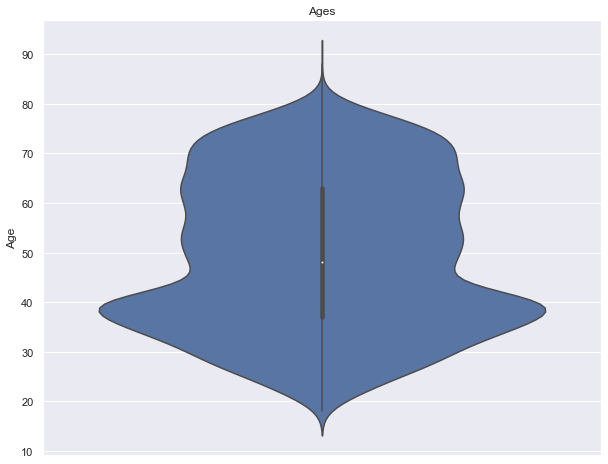

count    10192.000000
mean        49.567504
std         15.464799
min         18.000000
25%         37.000000
50%         48.000000
75%         63.000000
max         88.000000
Name: Age, dtype: float64

In [30]:
# plot distribution of ages
plt.figure(figsize=(10,8))
plt.title("Ages")
sns.axes_style("dark")
sns.violinplot(y=df["Age"])
plt.show()

# get some stats regarding the Age column
df.Age.describe()

In [31]:
# check if EducDeg makes sense according to Age
# min age is 18 so everyone can have an education up to High School
# check youngest people with a BSc/MSc
print("Minimum age associated to each Education Degree:")
print(df.groupby("EducDeg").Age.min())

# finishing a BSc (EducDeg = 3) at 20 yo is possible if starting at 17
# finishing a PhD (EducDeg = 4) at 23 yo is possible if skipping MSc and finishing PhD in 3 years (UK or outside of EU)
# no incoherences in EducDeg

Minimum age associated to each Education Degree:
EducDeg
1    18.0
2    19.0
3    20.0
4    23.0
Name: Age, dtype: float64


In [32]:
# create a Generation column based on birth year
df.loc[(df.BirthYear >= 1928) & (df.BirthYear <= 1945), "Generation"] = "Silent Generation"
df.loc[(df.BirthYear >= 1946) & (df.BirthYear <= 1964), "Generation"] = "Baby Boomer"
df.loc[(df.BirthYear >= 1965) & (df.BirthYear <= 1980), "Generation"] = "Generation X"
df.loc[(df.BirthYear >= 1981) & (df.BirthYear <= 1995), "Generation"] = "Millennial"
df.loc[(df.BirthYear >= 1996) & (df.BirthYear <= 2010), "Generation"] = "Generation Z"
df.loc[(df.BirthYear >= 2011) & (df.BirthYear <= 2025), "Generation"] = "Generation Alpha"

# convert Generation data to categorical
df.Generation = df.Generation.astype("category")

# get some stats regarding the Generation column
df.Generation.describe()

count            10192
unique               5
top       Generation X
freq              3441
Name: Generation, dtype: object

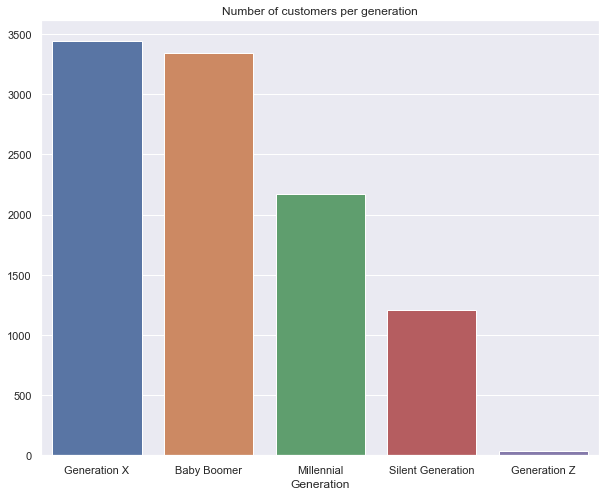

In [33]:
# count number of customers per generation
gen_count = df.groupby("Generation").size().sort_values(ascending=False)

# plot number of customers per generation
plt.figure(figsize=(10,8))
plt.title("Number of customers per generation")
sns.axes_style("dark")
sns.barplot(x = gen_count.index, y = gen_count.values, order = gen_count.index)
plt.show()

# if we replace age with generation, we should remove observations that are Generation Z

In [34]:
# create a YearSal column
# Premiums are also expressed as yearly values
# could be interesting to try YearSal as a categorical variable???
df.insert(5, "YearSal", df.MonthSal*12)

count    10192.000000
mean       750.818412
std        190.346723
min          0.000000
25%        626.240000
50%        697.130000
75%        823.032500
max       1804.440000
Name: PremTotal, dtype: float64


<AxesSubplot:xlabel='PremTotal'>

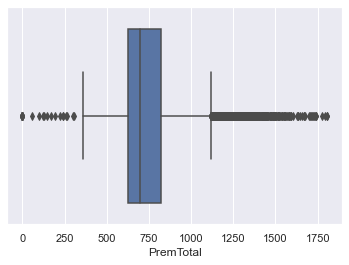

In [35]:
# create a PremTotal column
premium_cols = ["PremMotor", "PremHousehold", "PremHealth", "PremLife", "PremWork"]
df["PremTotal"] = df[premium_cols].sum(axis = 1)

# get some stats regarding the PremTotal column
print(df.PremTotal.describe())

# deal with PremTotal outliers??????????????
sns.boxplot(x = df.PremTotal)

In [36]:
# no observations where PremTotal is higher than the yearly salary
len(df[df.PremTotal > df.YearSal])

0

In [37]:
# what to do when no premiums were paid in 2016?????
# it could mean that the insurance was cancelled and they are no longer customers

# 12 observations with no Premiums paid in 2016
print(f"{len(df[df.PremTotal == 0])} customer(s) paid no Premium")
# removed these 12 observations as they likely represent past customers
df = df[~(df.PremTotal == 0)]

12 customer(s) paid no Premium


In [38]:
# create a CustYears column
# number of years a customer has been a customer
df["CustYears"] = curr_year - df.FirstPolYear

# get some stats regarding the CustYears column
df.CustYears.describe()

count    10180.000000
mean        28.368173
std          6.537370
min         15.000000
25%         23.000000
50%         28.000000
75%         34.000000
max         42.000000
Name: CustYears, dtype: float64

In [39]:
# PremHousehold, PremLife, PremWork skewed to the right
# probably need to apply a transformation? however...
# sqrt does not keep sign, maybe cube root?
# log cannot be applied without first dealing with the negative values (sum min val?)

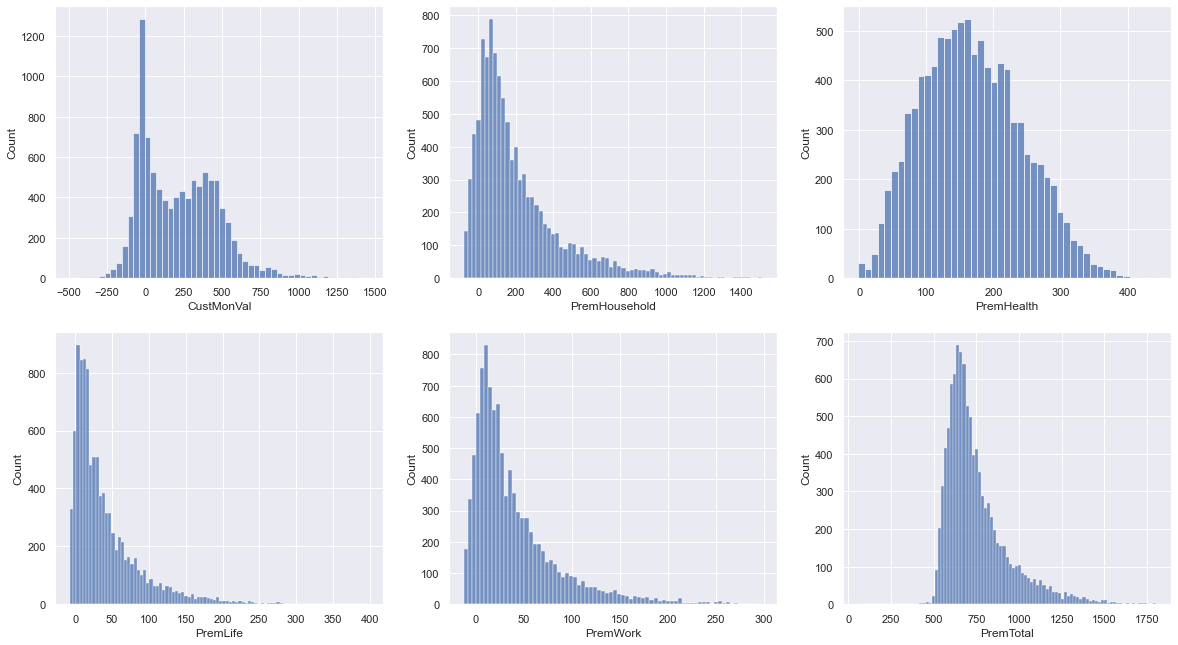

In [40]:
# CustMonVal, PremHousehold, PremHealth, PremLife, PremWork may require further processing
# histograms
skewed_metric_features = ["CustMonVal", "PremHousehold", "PremHealth", "PremLife", "PremWork", "PremTotal"]

sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, 3, figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), skewed_metric_features):
    sns.histplot(x=df[feat], ax=ax)
    
plt.show()

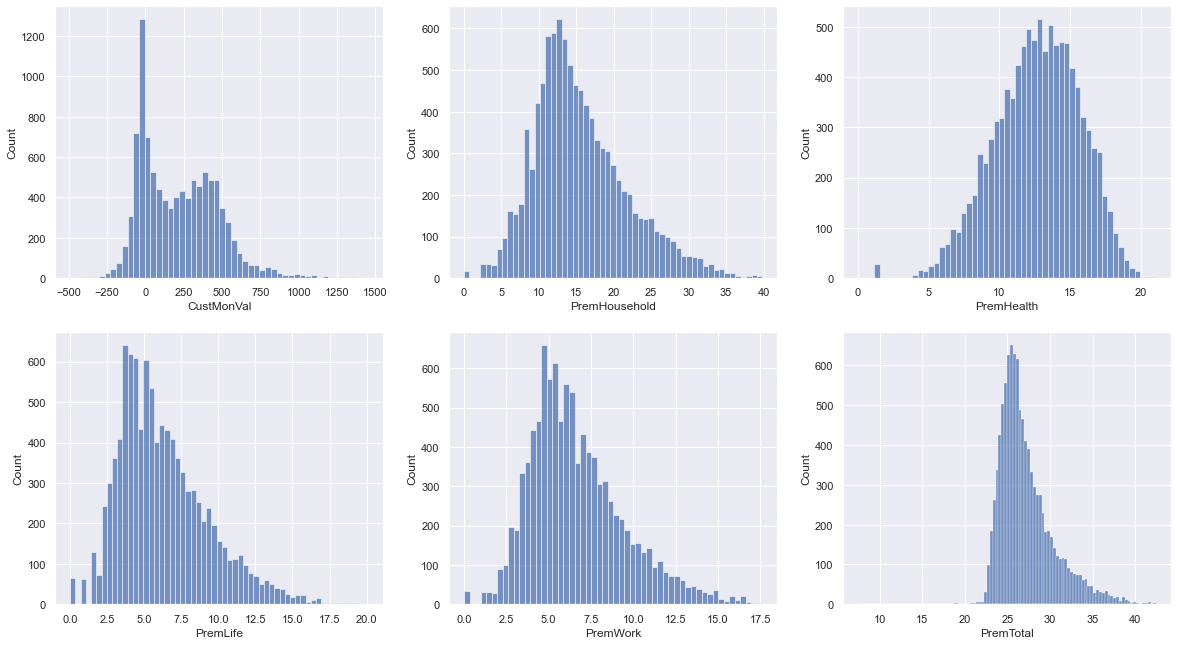

In [41]:
# summing the module of the minimum value to all observations
# applying transformation to normalize distributions
df.PremHousehold = np.sqrt(df.PremHousehold + 75)
df.PremHealth = np.sqrt(df.PremHealth + 2.11)
df.PremLife = np.sqrt(df.PremLife + 7)
df.PremWork = np.sqrt(df.PremWork + 12)
df.PremTotal = np.sqrt(df.PremTotal)

sns.set()

fig, axes = plt.subplots(2, 3, figsize=(20, 11))

for ax, feat in zip(axes.flatten(), skewed_metric_features):
    sns.histplot(x=df[feat], ax=ax)
    
plt.show()

In [42]:
# percentage of observations discarded
num_obs_discarded = len_df-len(df)
pc_obs_discarded = round(num_obs_discarded/len_df*100, 2)
print(f"Number of observations discarded: {num_obs_discarded} ({pc_obs_discarded} %)")

Number of observations discarded: 113 (1.1 %)


In [43]:
# new look at the dataframe
df

FirstPolYear  BirthYear   Age EducDeg  MonthSal  YearSal GeoLivArea  \
CustID                                                                        
1             1985.0     1982.0  34.0       2    2177.0  26124.0        1.0   
2             1995.0     1981.0  35.0       2     677.0   8124.0        4.0   
3             1991.0     1970.0  46.0       1    2277.0  27324.0        3.0   
4             1990.0     1981.0  35.0       3    1099.0  13188.0        4.0   
5             1986.0     1973.0  43.0       3    1763.0  21156.0        4.0   
...              ...        ...   ...     ...       ...      ...        ...   
10292         1984.0     1949.0  67.0       4    3188.0  38256.0        2.0   
10293         1977.0     1952.0  64.0       1    2431.0  29172.0        3.0   
10294         1994.0     1976.0  40.0       3    2918.0  35016.0        1.0   
10295         1981.0     1977.0  39.0       1    1971.0  23652.0        2.0   
10296         1990.0     1981.0  35.0       4    2815.0  33780.0        1.0   

       Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                          
1           1.0      380.97        0.39     375.85      12.427791   12.184827   
2           1.0     -131.13        1.12      77.46      22.163032   10.899541   
3           0.0      504.67        0.28     206.15      17.306068   11.255665   
4           1.0      -16.99        0.99     182.48      10.878879   17.699718   
5           1.0       35.23        0.90     338.62      11.081516   13.590438   
...         ...         ...         ...        ...            ...         ...   
10292       0.0       -0.11        0.96     393.74      11.155716   13.263484   
10293       0.0     1405.60        0.00     133.58      33.327916   12.056533   
10294       1.0      524.10        0.21     403.63      14.415270   12.014991   
10295       1.0      250.05        0.65     188.59      16.915969   14.159096   
10296       1.0      463.75        0.27     414.08      13.017296   11.973304   

         PremLife   PremWork    Generation  PremTotal  CustYears  
CustID                                                            
1        7.349150   5.374942    Millennial  25.798450       31.0  
2       14.194365  10.868763    Millennial  30.182114       21.0  
3        9.661780  10.536603  Generation X  27.213967       25.0  
4        6.506919   6.351378    Millennial  24.508774       26.0  
5        5.077401   7.310951  Generation X  25.084657       30.0  
...           ...        ...           ...        ...        ...  
10292    4.096340   5.174940   Baby Boomer  25.329035       32.0  
10293    4.459821  10.822661   Baby Boomer  37.823273       39.0  
10294    4.435087   4.109745  Generation X  26.386360       22.0  
10295    8.420214  11.176314  Generation X  27.837385       35.0  
10296    3.726929   4.988988    Millennial  25.875857       26.0  

[10180 rows x 18 columns]

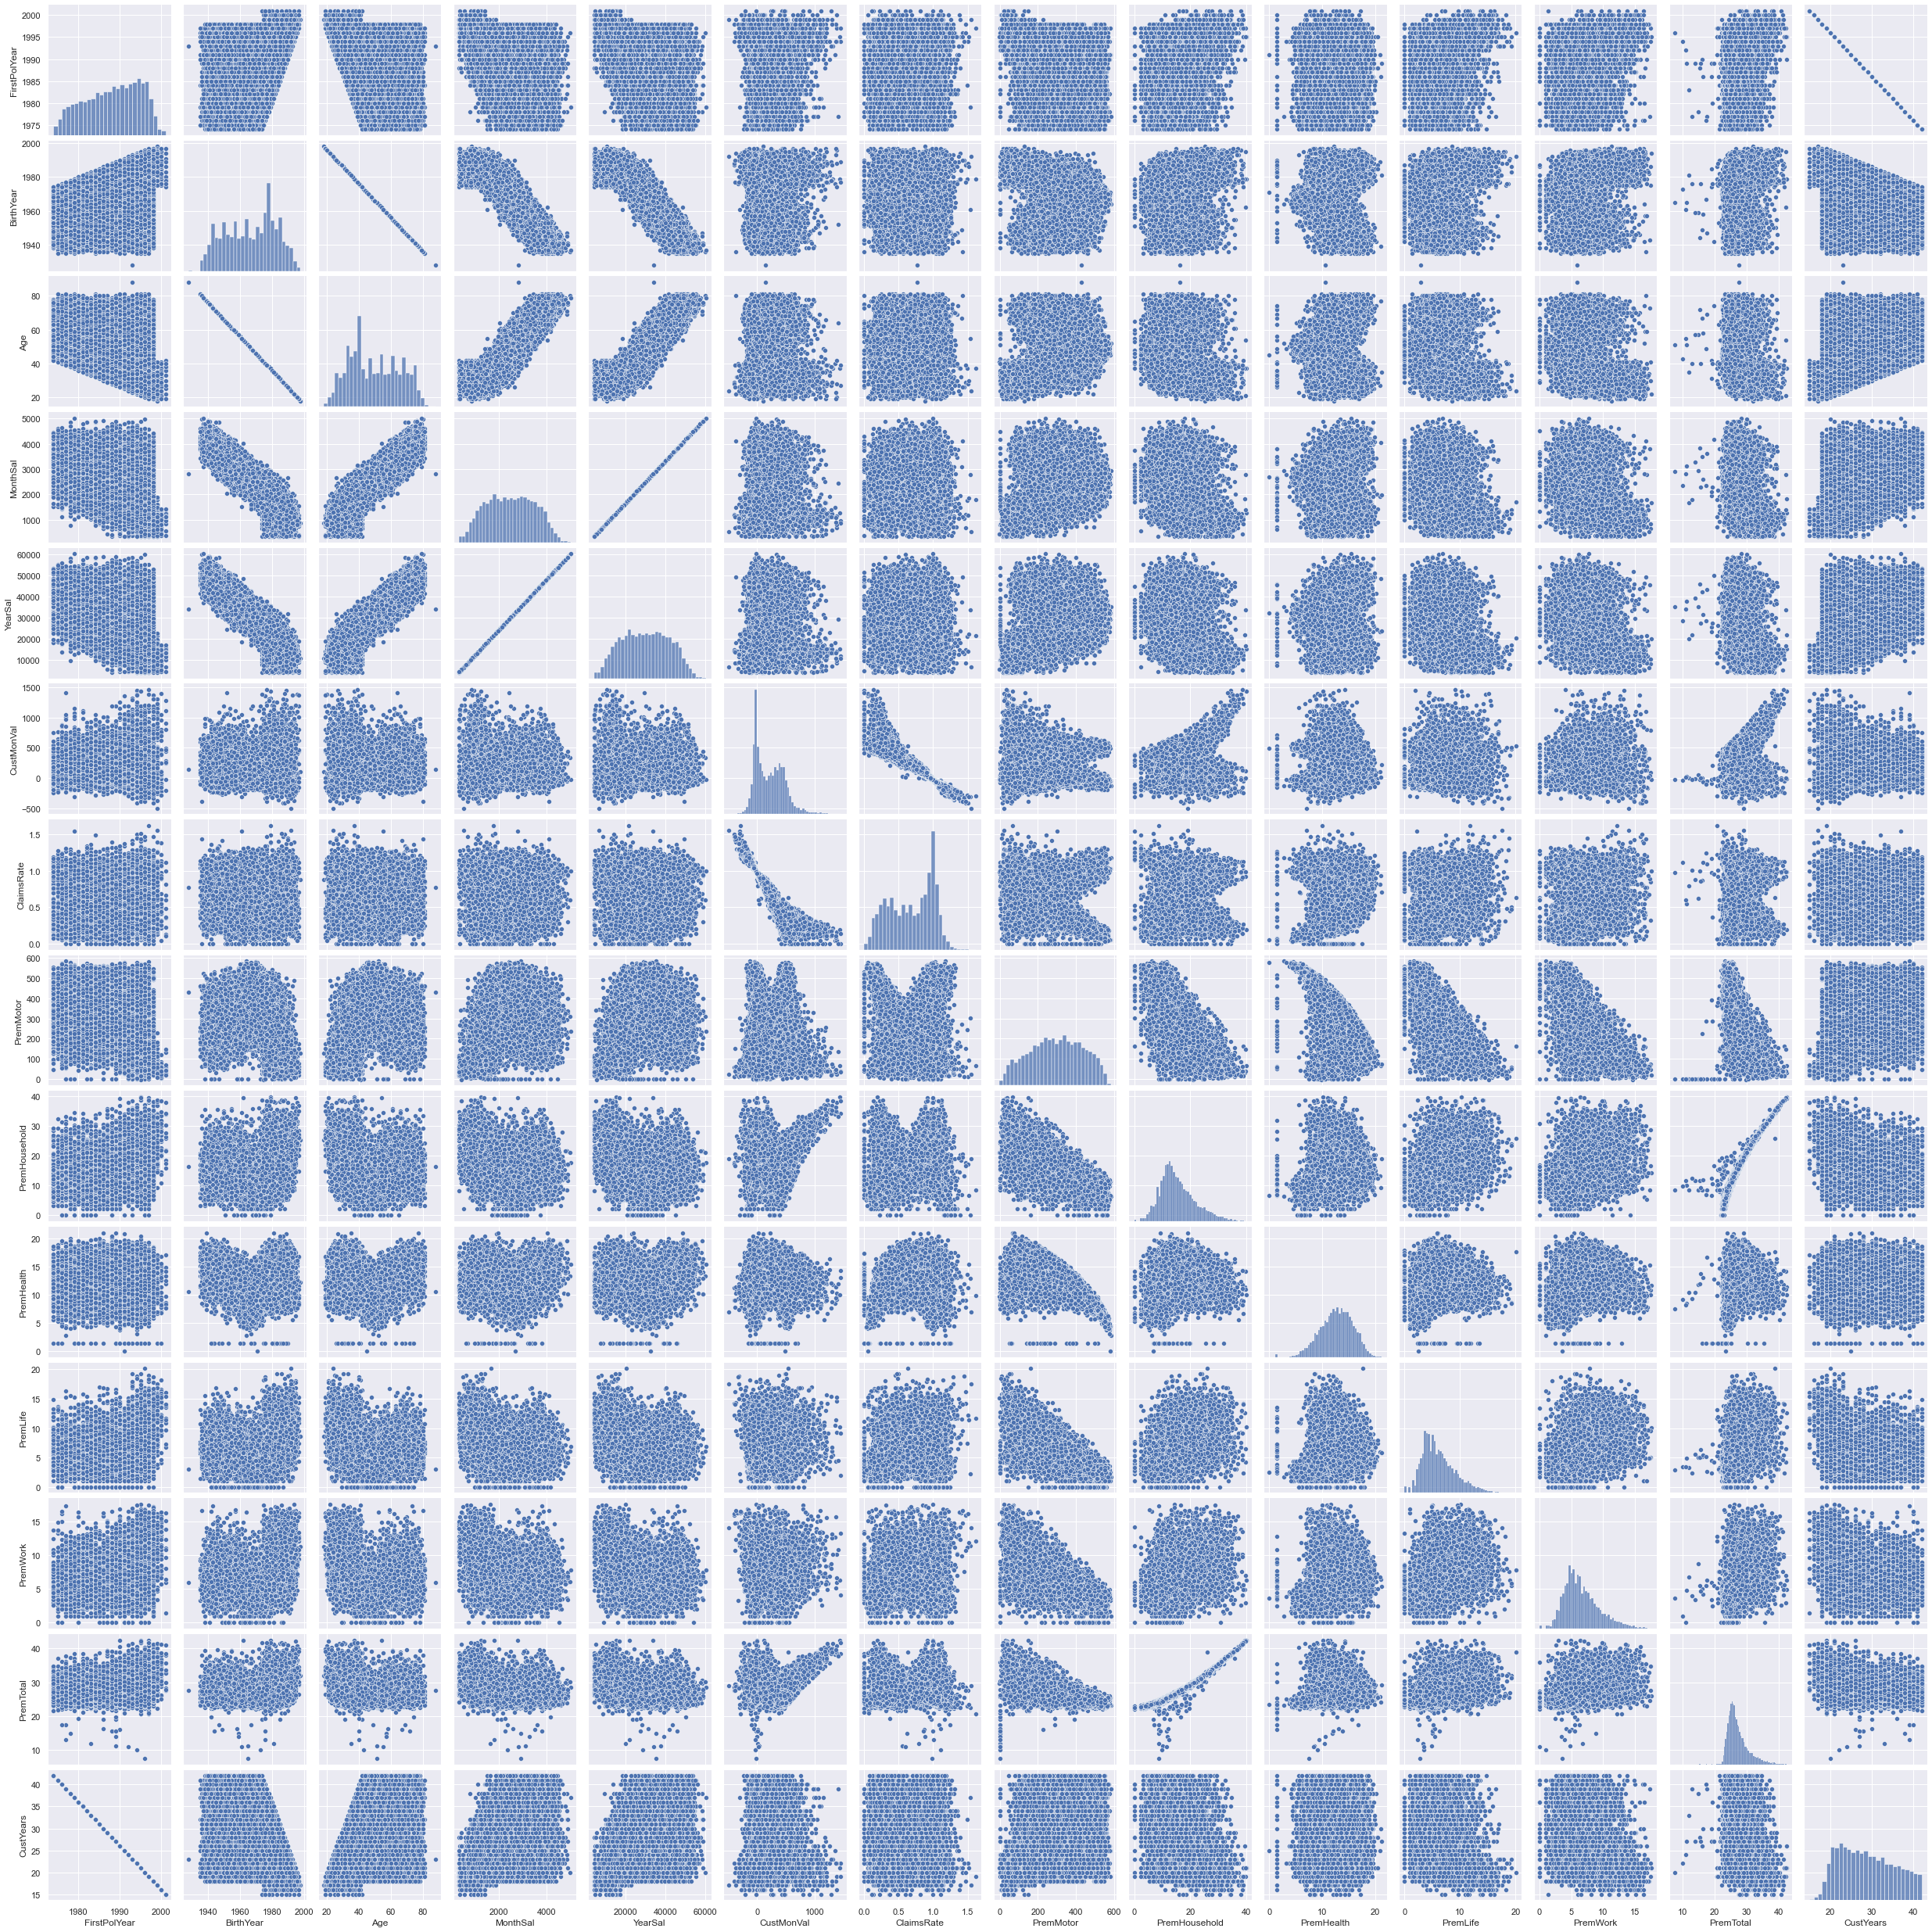

In [44]:
# bidimensional representation of metric attributes
sns.pairplot(df)

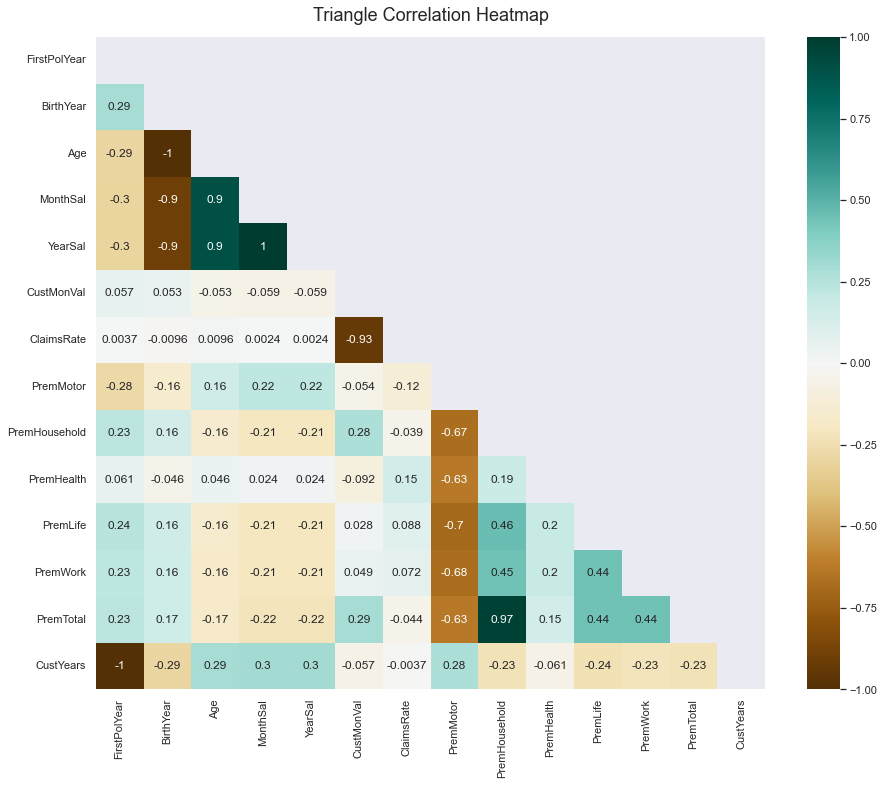

In [45]:
# create a heatmap showing correlation between all metric attributes
# pearson, spearman ????????????????
plt.subplots(figsize=(15,12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
corr_heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
corr_heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [46]:
# high correlations:
# FirstPoLYear redundant with CustYears, remove FirstPoLYear as the latter is more intuitive to work with
# Age redundant with BirthYear, remove BirthYear as Age is more intuitive to work with
# MonthSal redundant with YearSal, remove MonthSal as Premiums are also yearly values
# CustMonVal redundant with ClaimsRate, and ClaimsRate not correlated with anything else, remove ClaimsRate
# 
df.drop(columns = ["FirstPolYear", "BirthYear", "ClaimsRate", "MonthSal"], inplace = True)

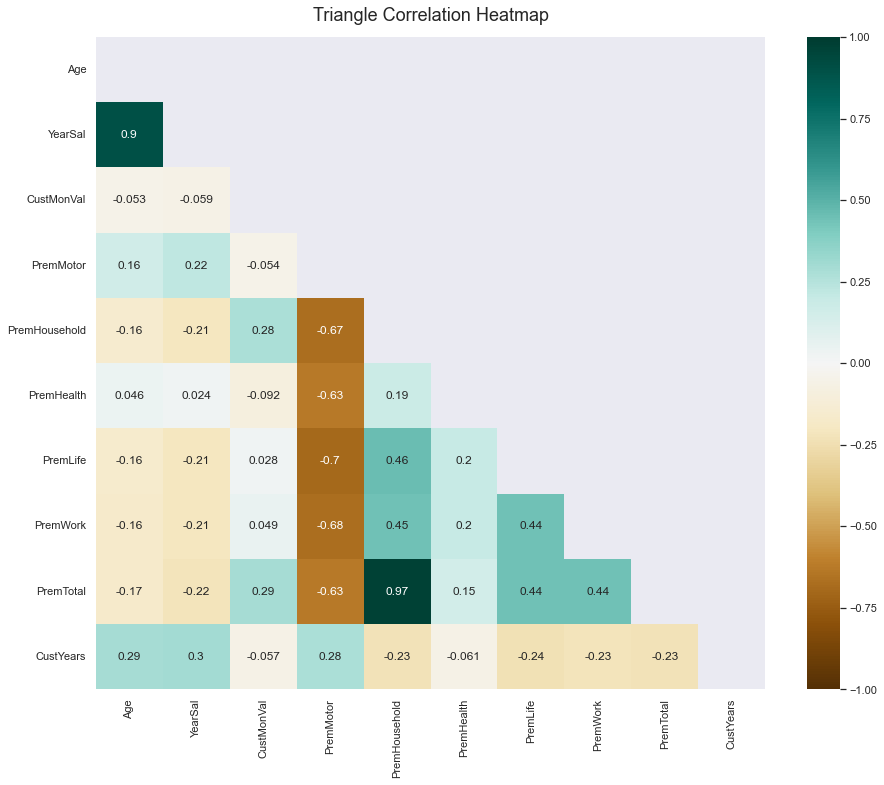

In [47]:
# create a heatmap showing correlation between the metric attributes selected
plt.subplots(figsize=(15,12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
corr_heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
corr_heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [48]:
# updating metric and non-metric features
metric_features = df.select_dtypes(include = np.number).columns.tolist()
non_metric_features = df.columns.drop(metric_features).tolist()

print("Metric Features:", metric_features)
print("Non-metric Features:", non_metric_features)

Metric Features: ['Age', 'YearSal', 'CustMonVal', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'PremTotal', 'CustYears']
Non-metric Features: ['EducDeg', 'GeoLivArea', 'Children', 'Generation']


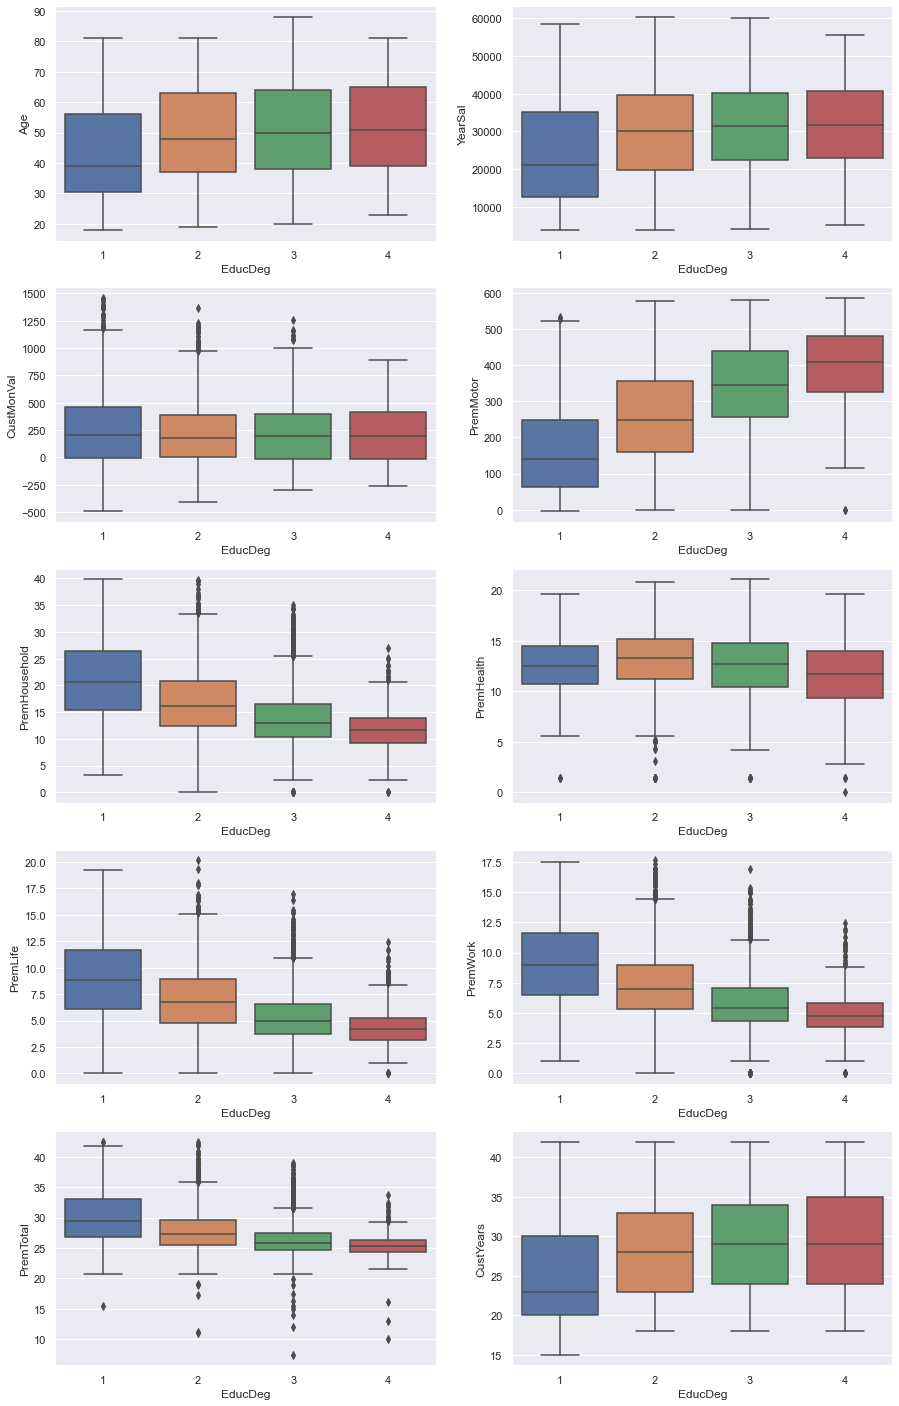

In [49]:
# explore EducDeg categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["EducDeg"], y=df[feat], ax=ax)
    
plt.show()

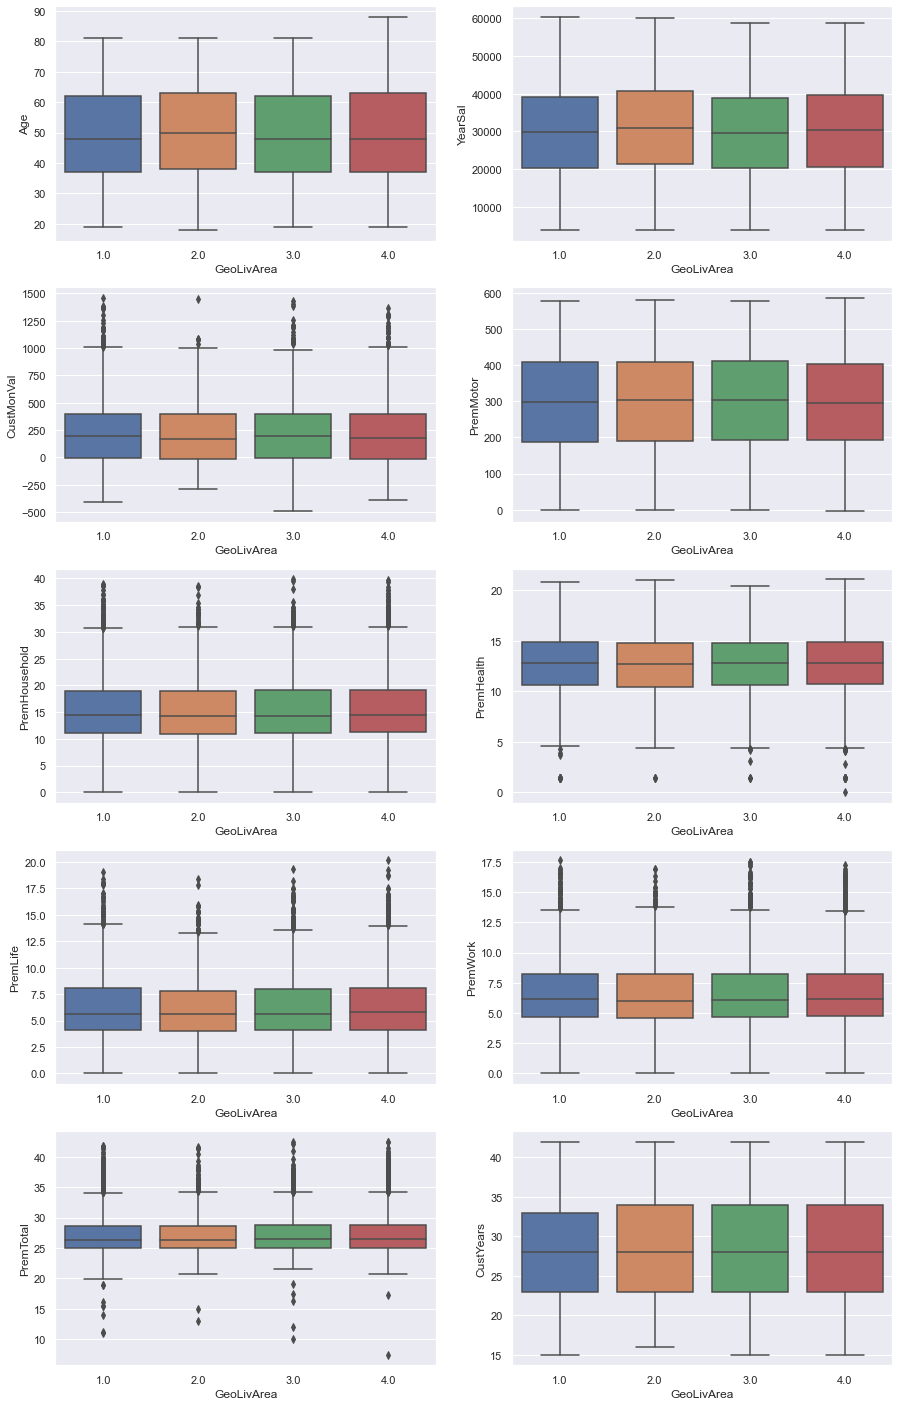

In [50]:
# we do not know much about GeoLivArea or how relevant it might be
# explore GeoLivArea categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["GeoLivArea"], y=df[feat], ax=ax)
    
plt.show()

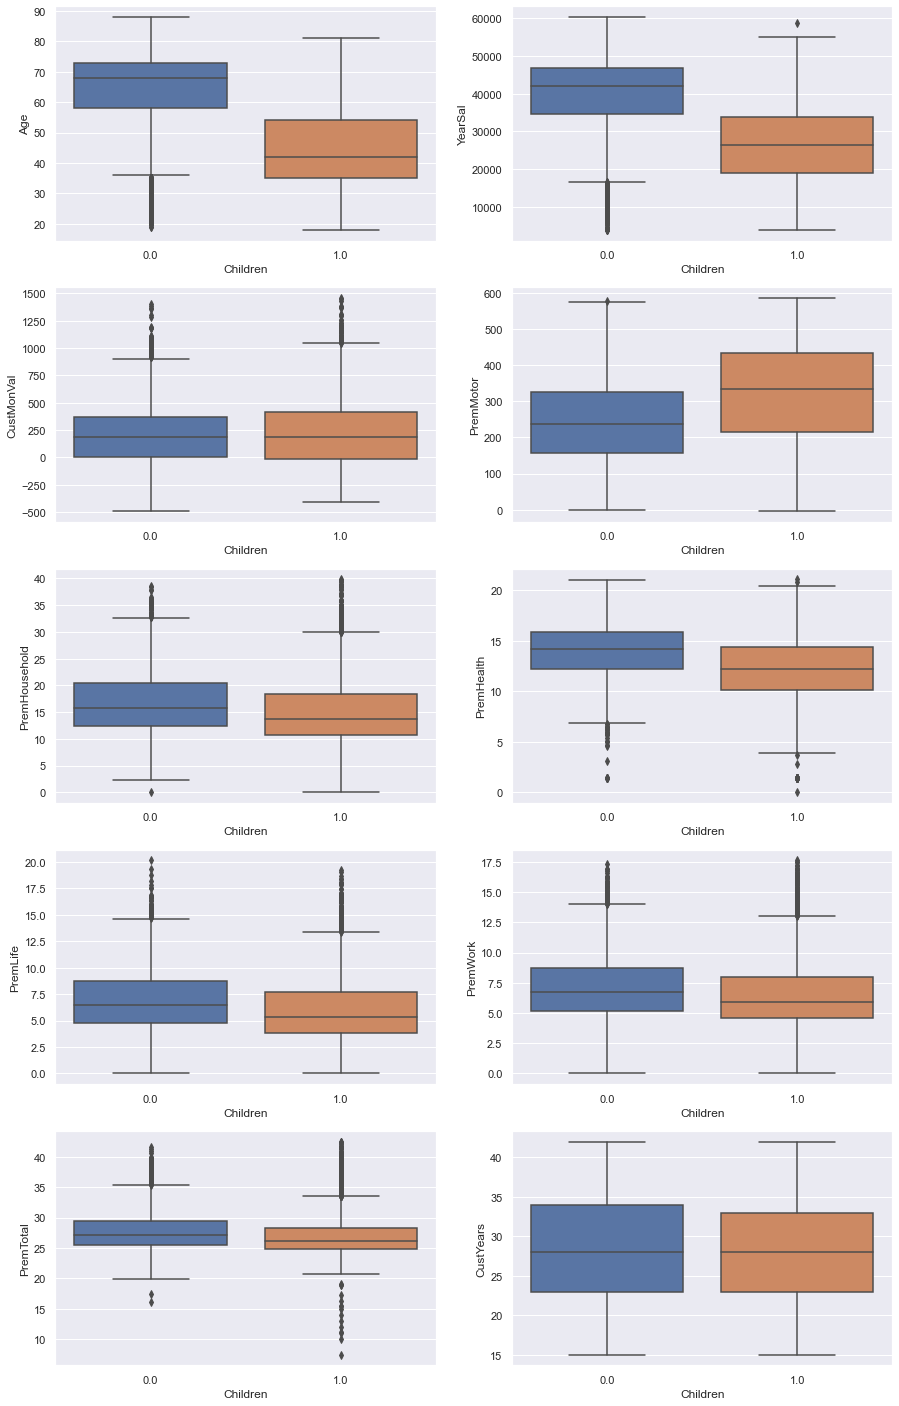

In [51]:
# explore Children categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["Children"], y=df[feat], ax=ax)
    
plt.show()

# kinda weird that median age of people with children is lower than for people without?

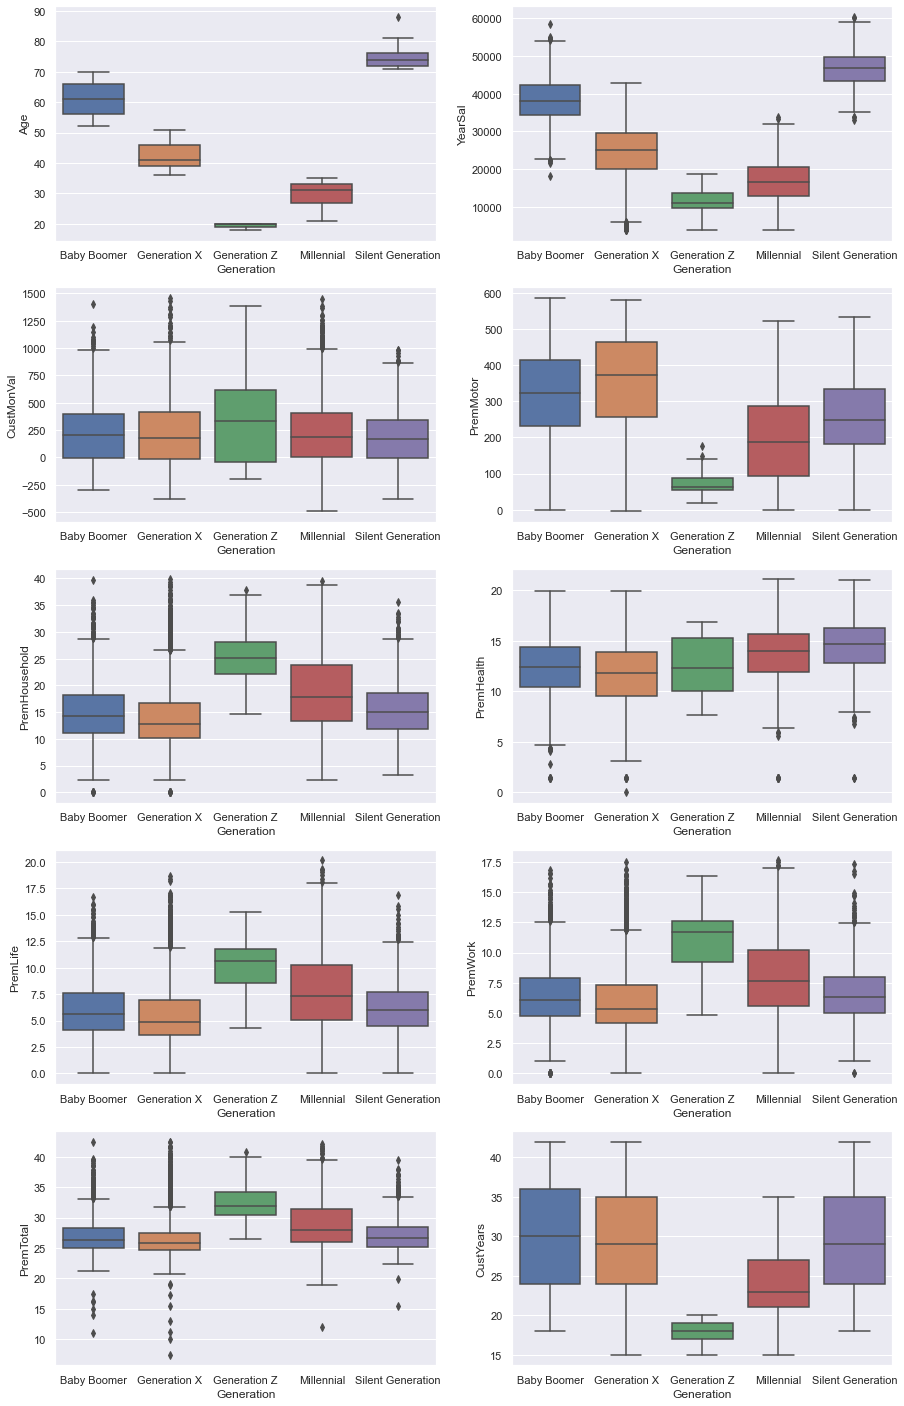

In [52]:
# explore Generation categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["Generation"], y=df[feat], ax=ax)
    
plt.show()

In [53]:
# Children and EducDeg appear to have some discriminating power
# Generation also appears to be interesting if we use age as categorical
# GeoLivArea does not seem to be particularly useful
df.drop(columns = "GeoLivArea", inplace = True)

# should we retrieve the 1 observation removed because GeoLivArea was NaN??????????

In [54]:
# reorganizing dataframe to be more intuitive
df = df.loc[:, ["Generation",
                "Age", 
                "EducDeg", 
                "Children", 
                "YearSal", 
                "CustYears", 
                "CustMonVal", 
                "PremMotor", 
                "PremHousehold", 
                "PremHealth", 
                "PremLife", 
                "PremWork", 
                "PremTotal"]]

df.head()

Generation   Age EducDeg Children  YearSal  CustYears  CustMonVal  \
CustID                                                                        
1         Millennial  34.0       2      1.0  26124.0       31.0      380.97   
2         Millennial  35.0       2      1.0   8124.0       21.0     -131.13   
3       Generation X  46.0       1      0.0  27324.0       25.0      504.67   
4         Millennial  35.0       3      1.0  13188.0       26.0      -16.99   
5       Generation X  43.0       3      1.0  21156.0       30.0       35.23   

        PremMotor  PremHousehold  PremHealth   PremLife   PremWork  PremTotal  
CustID                                                                         
1          375.85      12.427791   12.184827   7.349150   5.374942  25.798450  
2           77.46      22.163032   10.899541  14.194365  10.868763  30.182114  
3          206.15      17.306068   11.255665   9.661780  10.536603  27.213967  
4          182.48      10.878879   17.699718   6.506919   6.351378  24.508774  
5          338.62      11.081516   13.590438   5.077401   7.310951  25.084657

## Scale metric features and encode categories as binary features

In [55]:
# updating metric and non-metric features
df.EducDeg = df.EducDeg.astype("float")
metric_features = df.select_dtypes(include = np.number).columns.tolist()
non_metric_features = df.columns.drop(metric_features).tolist()

print("Metric Features:", metric_features)
print("Non-metric Features:", non_metric_features)

Metric Features: ['Age', 'EducDeg', 'YearSal', 'CustYears', 'CustMonVal', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'PremTotal']
Non-metric Features: ['Generation', 'Children']


In [56]:
# scale metric features and store them as df_scaled
# alternative: StandardScaler (got better results with MinMaxScaler)
# create a dataframe with the scaled metric variables
df_scaled = df.copy()
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_scaled[metric_features])
df_scaled[metric_features] = scaled_feat
df_scaled[metric_features].describe().round(2).T

count  mean   std  min   25%   50%   75%  max
Age            10180.0  0.45  0.22  0.0  0.27  0.43  0.64  1.0
EducDeg        10180.0  0.49  0.26  0.0  0.33  0.67  0.67  1.0
YearSal        10180.0  0.46  0.21  0.0  0.29  0.46  0.63  1.0
CustYears      10180.0  0.50  0.24  0.0  0.30  0.48  0.70  1.0
CustMonVal     10180.0  0.36  0.13  0.0  0.25  0.35  0.46  1.0
PremMotor      10180.0  0.51  0.23  0.0  0.33  0.51  0.70  1.0
PremHousehold  10180.0  0.39  0.16  0.0  0.28  0.36  0.48  1.0
PremHealth     10180.0  0.60  0.14  0.0  0.51  0.61  0.70  1.0
PremLife       10180.0  0.31  0.15  0.0  0.20  0.28  0.40  1.0
PremWork       10180.0  0.38  0.16  0.0  0.27  0.35  0.47  1.0
PremTotal      10180.0  0.56  0.09  0.0  0.50  0.54  0.61  1.0

In [57]:
# OneHotEncode categorical variables
# store OneHotEncoded categorical variables in df_ohc
df_ohc = df_scaled.copy()
ohc = OneHotEncoder(sparse = False, drop = "if_binary")
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
df_ohc = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)

# renaming columns of cat features after one hot encoder
new_names = {"x0_Baby Boomer": "BabyBoomer",
             "x0_Generation X": "GenX",
             "x0_Generation Z": "GenZ",
             "x0_Millennial": "Millennial",
             "x0_Silent Generation": "SilentGen",
             "x1_1": "Basic",
             "x1_2": "HighSchool",
             "x1_3": "BSc/MSc",
             "x1_4": "PhD",
             "x2_1.0": "Children"}
df_ohc.rename(mapper = new_names, axis = 1, inplace = True)

In [58]:
# there are three dataframes at this point
# the dataframe obtained prior to normalisation and OneHotEncoding
# note: premium values are actually the square root of the original values
df.describe(include="all").T

count unique           top    freq         mean  \
Generation       10180      5  Generation X    3441          NaN   
Age            10180.0    NaN           NaN     NaN    49.570629   
EducDeg        10180.0    NaN           NaN     NaN     2.482024   
Children       10180.0    2.0           1.0  7200.0          NaN   
YearSal        10180.0    NaN           NaN     NaN  30012.21735   
CustYears      10180.0    NaN           NaN     NaN    28.368173   
CustMonVal     10180.0    NaN           NaN     NaN   217.469359   
PremMotor      10180.0    NaN           NaN     NaN   296.934943   
PremHousehold  10180.0    NaN           NaN     NaN     15.52124   
PremHealth     10180.0    NaN           NaN     NaN    12.675762   
PremLife       10180.0    NaN           NaN     NaN     6.273075   
PremWork       10180.0    NaN           NaN     NaN      6.65684   
PremTotal      10180.0    NaN           NaN     NaN    27.226313   

                        std       min        25%        50%        75%  \
Generation              NaN       NaN        NaN        NaN        NaN   
Age               15.460569      18.0       37.0       48.0       63.0   
EducDeg             0.79366       1.0        2.0        3.0        3.0   
Children                NaN       NaN        NaN        NaN        NaN   
YearSal        11791.158949    3996.0    20520.0    30048.0    39495.0   
CustYears           6.53737      15.0       23.0       28.0       34.0   
CustMonVal       254.835551    -490.2      -8.44     187.26     399.08   
PremMotor         138.18411     -4.11     190.59      298.5     407.52   
PremHousehold      6.288019       0.0  11.155716   14.41527  19.106282   
PremHealth         3.017054       0.0  10.672863  12.842118  14.871113   
PremLife           3.016078       0.0   4.109745    5.69649   8.000625   
PremWork            2.81027       0.0   4.690416   6.128621   8.240146   
PremTotal          3.229915  7.454529  25.031181  26.405397  28.691288   

                     max  
Generation           NaN  
Age                 88.0  
EducDeg              4.0  
Children             NaN  
YearSal          60252.0  
CustYears           42.0  
CustMonVal       1455.94  
PremMotor         585.22  
PremHousehold  39.850345  
PremHealth     21.094312  
PremLife       20.132064  
PremWork        17.62101  
PremTotal      42.478701

In [59]:
# the dataframe with the scaled metric variables
df_scaled.describe().T

count      mean       std  min       25%       50%       75%  \
Age            10180.0  0.451009  0.220865  0.0  0.271429  0.428571  0.642857   
EducDeg        10180.0  0.494008  0.264553  0.0  0.333333  0.666667  0.666667   
YearSal        10180.0  0.462461  0.209598  0.0  0.293729  0.463097  0.631026   
CustYears      10180.0  0.495118  0.242125  0.0  0.296296  0.481481  0.703704   
CustMonVal     10180.0  0.363627  0.130944  0.0  0.247546  0.348104  0.456946   
PremMotor      10180.0  0.510826  0.234477  0.0  0.330375  0.513481  0.698471   
PremHousehold  10180.0  0.389488  0.157791  0.0  0.279940  0.361735  0.479451   
PremHealth     10180.0  0.600909  0.143027  0.0  0.505959  0.608795  0.704982   
PremLife       10180.0  0.311596  0.149815  0.0  0.204139  0.282956  0.397407   
PremWork       10180.0  0.377779  0.159484  0.0  0.266183  0.347802  0.467632   
PremTotal      10180.0  0.564518  0.092220  0.0  0.501843  0.541080  0.606346   

               max  
Age            1.0  
EducDeg        1.0  
YearSal        1.0  
CustYears      1.0  
CustMonVal     1.0  
PremMotor      1.0  
PremHousehold  1.0  
PremHealth     1.0  
PremLife       1.0  
PremWork       1.0  
PremTotal      1.0

In [60]:
# the dataframe with the OneHotEncoded categorical variables
df_ohc.describe(include="all").T

count      mean       std  min  25%  50%  75%  max
BabyBoomer  10180.0  0.327603  0.469362  0.0  0.0  0.0  1.0  1.0
GenX        10180.0  0.338016  0.473057  0.0  0.0  0.0  1.0  1.0
GenZ        10180.0  0.003340  0.057698  0.0  0.0  0.0  0.0  1.0
Millennial  10180.0  0.212279  0.408941  0.0  0.0  0.0  0.0  1.0
SilentGen   10180.0  0.118762  0.323524  0.0  0.0  0.0  0.0  1.0
x1_1.0      10180.0  0.707269  0.455038  0.0  0.0  1.0  1.0  1.0

# Sociodemographic clustering

Attempted sociodemographic clustering using different algorithms.
KPrototypes was used first to handle Children as a categorical variable, and clusters were agglomerated based on the visualisation of a dendrogram.
AgglomerativeClustering and KMeans produce the exact same clusters, and these are very similar to KPrototypes. However, there is perfect split between people with and without children (KPrototypes also splits them into two groups but they are not pure).

In [61]:
# attempting sociodemographic clustering
# include age, yearly salary, education degree, and children
# sociodemographic dataframe
df_sociodem = df[["Age", "YearSal", "EducDeg", "Children"]]
df_sociodem

Age  YearSal  EducDeg Children
CustID                                 
1       34.0  26124.0      2.0      1.0
2       35.0   8124.0      2.0      1.0
3       46.0  27324.0      1.0      0.0
4       35.0  13188.0      3.0      1.0
5       43.0  21156.0      3.0      1.0
...      ...      ...      ...      ...
10292   67.0  38256.0      4.0      0.0
10293   64.0  29172.0      1.0      0.0
10294   40.0  35016.0      3.0      1.0
10295   39.0  23652.0      1.0      1.0
10296   35.0  33780.0      4.0      1.0

[10180 rows x 4 columns]

## KPrototypes

In [62]:
# scaled df_sociodem to use with KPrototypes
df_sociodem_kp = pd.concat([df_scaled[["Age", "YearSal", "EducDeg"]], df["Children"]], axis=1)
df_sociodem_kp

Age   YearSal   EducDeg Children
CustID                                       
1       0.228571  0.393345  0.333333      1.0
2       0.242857  0.073379  0.333333      1.0
3       0.400000  0.414676  0.000000      0.0
4       0.242857  0.163396  0.666667      1.0
5       0.357143  0.305034  0.666667      1.0
...          ...       ...       ...      ...
10292   0.700000  0.609002  1.000000      0.0
10293   0.657143  0.447526  0.000000      0.0
10294   0.314286  0.551408  0.666667      1.0
10295   0.300000  0.349403  0.000000      1.0
10296   0.242857  0.529437  1.000000      1.0

[10180 rows x 4 columns]

In [63]:
def plot_elbow(max_clusters, data, cat_index):
    
    n_clusters = np.arange(2, max_clusters+1)
    cost_values = []
    silhouette_values = []
    
    for n in n_clusters:
        kp_model = KPrototypes(n_clusters = n, init = "Huang", random_state = 15)
        kp_model.fit_predict(data, categorical = cat_index)
        cost_values.append(kp_model.cost_)
        silhouette_values.append(silhouette_score(data, kp_model.labels_))
        
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(n_clusters, cost_values)
    axes[1].plot(n_clusters, silhouette_values)
    
    return

# uncomment code line to make an elbow plot based on KPrototypes cost
# Warning: takes a few minutes
# plot_elbow(15, df_sociodem_kp, [3])

In [64]:
# KPrototypes to make cluster predictions
kp_model = KPrototypes(n_clusters = 15, init = "Huang", random_state = 15)
kp_model.fit_predict(df_sociodem_kp, categorical = [3])

array([13, 13, 14, ...,  8, 11,  0], dtype=uint16)

In [65]:
# get labels and centroids from the model
labels = kp_model.labels_
centroids = kp_model.cluster_centroids_

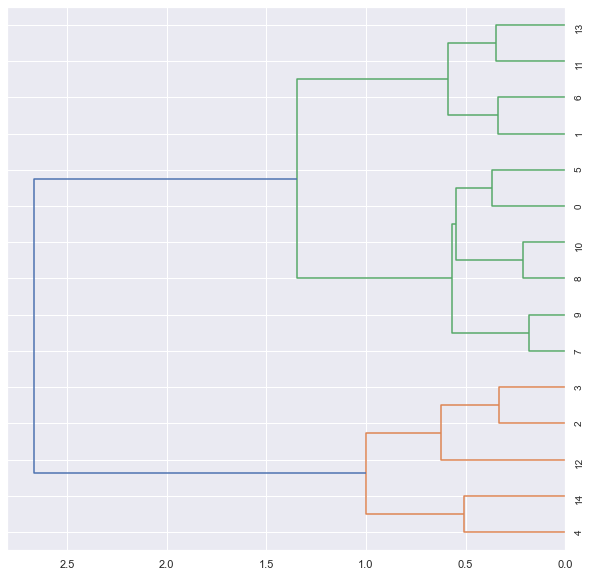

In [66]:
# what type of method to use for linkage???????????
ward_linkage = hierarchy.linkage(centroids, method = "ward")

# dendrogram
plt.subplots(figsize=(10,10))
hierarchy.dendrogram(ward_linkage,
                     orientation ="left" ,
                     leaf_rotation=90.,
                     leaf_font_size=10.,
                     show_contracted=True,
                     show_leaf_counts=True);

In [67]:
df_sociodem["Cluster"] = labels

In [68]:
# Two clusters will simply separate between people who have children (~70%) and people who don't (~30%)
# Four clusters will separate the people who don't have children into two clusters, one of which has few observations
# Three clusters seems like the sweet spot:
# - it splits people who have children (who are the majority) into two groups of different education levels
# - it keeps people who do not have children in a single group (which also tends to be older and wealthier)

cluster0 = df_sociodem[(df_sociodem.Cluster == 13)
                       | (df_sociodem.Cluster == 11)
                       | (df_sociodem.Cluster == 6)
                       | (df_sociodem.Cluster == 1)]
cluster0["Cluster"] = 0

cluster1 = df_sociodem[(df_sociodem.Cluster == 5)
                       | (df_sociodem.Cluster == 0)
                       | (df_sociodem.Cluster == 10)
                       | (df_sociodem.Cluster == 8)
                       | (df_sociodem.Cluster == 9)
                       | (df_sociodem.Cluster == 7)]
cluster1["Cluster"] = 1

cluster2 = df_sociodem[(df_sociodem.Cluster == 3)
                       | (df_sociodem.Cluster == 2)
                       | (df_sociodem.Cluster == 12)
                       | (df_sociodem.Cluster == 14)
                       | (df_sociodem.Cluster == 4)]
cluster2["Cluster"] = 2

df_sociodem_upd = pd.concat([cluster0, cluster1, cluster2], axis=0)

In [69]:
# let's take a quick look at the numbers for each cluster
print("Mean features values for each cluster:")
print(df_sociodem_upd.groupby("Cluster").mean())

# what about children?
print("\nNumber of people with and without children in each cluster:")
print(df_sociodem_upd.groupby("Cluster").Children.value_counts().sort_index())

Mean features values for each cluster:
               Age       YearSal   EducDeg
Cluster                                   
0        42.518597  24816.029382  1.736317
1        45.543501  27739.518779  3.134340
2        62.744013  38803.279618  2.453963

Number of people with and without children in each cluster:
Cluster     
0        0.0       7
         1.0    3300
1        0.0      41
         1.0    3867
2        0.0    2932
         1.0      33
Name: Children, dtype: int64


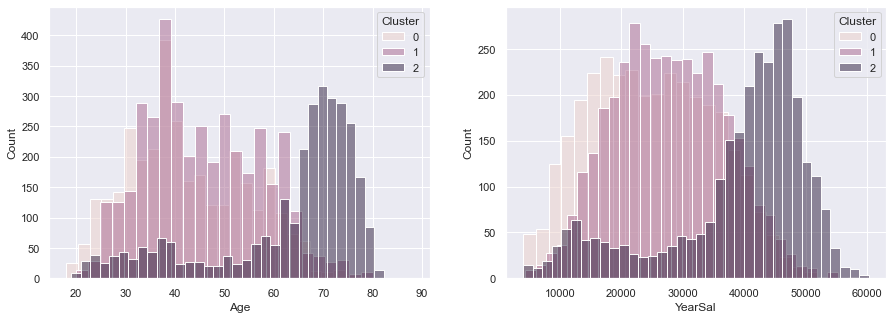

In [70]:
# represent the continuous features, Age and YearSal, for all three clusters as a histogram
cont_sociodem_feats = ["Age", "YearSal"]
other_sociodem_feats = ["Children", "EducDeg"]
n_clusters = np.arange(df_sociodem_upd.Cluster.max()+1)

sns.set()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, feat in zip(axes.flatten(), cont_sociodem_feats):
    for n in n_clusters:
        cluster_feat = df_sociodem_upd[df_sociodem_upd.Cluster == n][feat]
        sns.histplot(data = df_sociodem_upd, x = cluster_feat, ax = ax, hue = "Cluster")
        
plt.show()

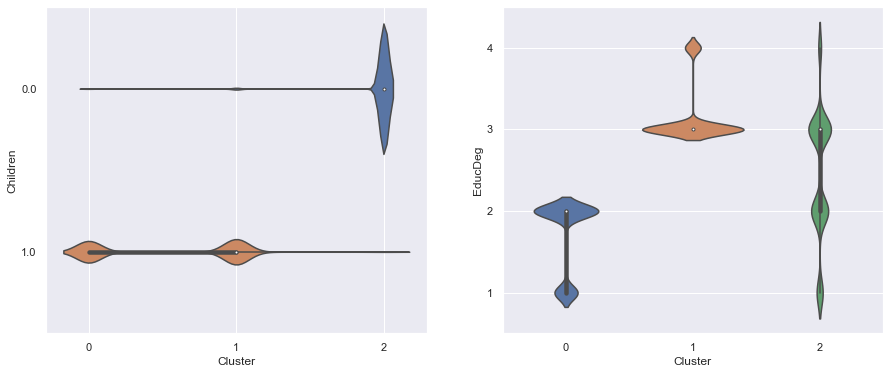

In [71]:
sns.set()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for ax, feat in zip(axes.flatten(), other_sociodem_feats):
    sns.violinplot(data = df_sociodem_upd, x = "Cluster", y = feat, ax = ax)
    ax.set_xticks(np.arange(0, df_sociodem_upd.Cluster.max()+1))
    
axes[1].set_yticks(np.arange(1, df_sociodem_upd.EducDeg.max()+1));

In [72]:
# Using KPrototypes to cluster clients based on sociodemographic data, we found that:
# - we can split the clients into three clusters
# - people in Clusters 0 and 1 have similar age and income distributions and usually have children
# - however, people in Cluster 0 tend to be less educated (HSch or lower) than people in Cluster 1 (BSc or higher)
# - people in Cluster 2 generally do not have children, and tend to be older and have a higher income than those in the other two clusters

In [73]:
#sns.pairplot()

## Agglomerative clustering

In [91]:
df_sociodem_ac = pd.concat([df_scaled[["Age", "YearSal", "EducDeg"]], df["Children"]], axis=1)
df_sociodem_ac

Age   YearSal   EducDeg Children
CustID                                       
1       0.228571  0.393345  0.333333      1.0
2       0.242857  0.073379  0.333333      1.0
3       0.400000  0.414676  0.000000      0.0
4       0.242857  0.163396  0.666667      1.0
5       0.357143  0.305034  0.666667      1.0
...          ...       ...       ...      ...
10292   0.700000  0.609002  1.000000      0.0
10293   0.657143  0.447526  0.000000      0.0
10294   0.314286  0.551408  0.666667      1.0
10295   0.300000  0.349403  0.000000      1.0
10296   0.242857  0.529437  1.000000      1.0

[10180 rows x 4 columns]

In [92]:
ac_model = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward").fit(df_sociodem_ac)
df_sociodem["Cluster"] = ac_model.labels_

In [93]:
df_sociodem.groupby("Cluster").mean()

Age       YearSal   EducDeg
Cluster                                   
0        62.340268  38487.167808  2.479195
1        42.825383  25051.942744  1.737774
2        45.543832  27756.526348  3.125679

In [94]:
df_sociodem.groupby("Cluster").Children.value_counts().sort_index()

Cluster     
0        0.0    2980
         1.0       0
1        0.0       0
         1.0    3333
2        0.0       0
         1.0    3867
Name: Children, dtype: int64

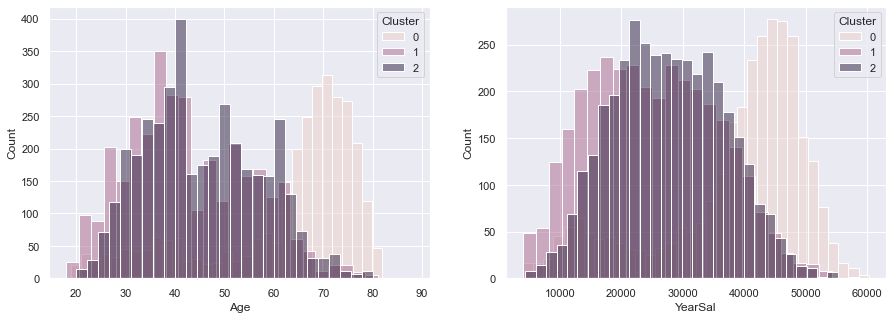

In [95]:
# represent the continuous features, Age and YearSal, for all three clusters as a histogram
cont_sociodem_feats = ["Age", "YearSal"]
other_sociodem_feats = ["Children", "EducDeg"]
n_clusters = np.arange(df_sociodem.Cluster.max()+1)

sns.set()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, feat in zip(axes.flatten(), cont_sociodem_feats):
    for n in n_clusters:
        cluster_feat = df_sociodem[df_sociodem.Cluster == n][feat]
        sns.histplot(data = df_sociodem, x = cluster_feat, ax = ax, hue = "Cluster")
        
plt.show()

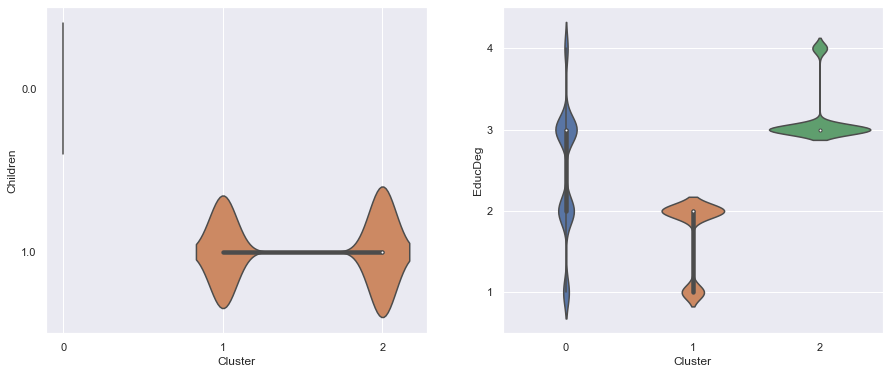

In [96]:
sns.set()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for ax, feat in zip(axes.flatten(), other_sociodem_feats):
    sns.violinplot(data = df_sociodem, x = "Cluster", y = feat, ax = ax)
    ax.set_xticks(np.arange(0, df_sociodem.Cluster.max()+1))
    
axes[1].set_yticks(np.arange(1, df_sociodem.EducDeg.max()+1));

In [97]:
# data in the left plot is ok but why is it kinda funky????
# results very similar to KPrototypes + agglomeration based on dendrogram
# main difference: using AgglomerativeClustering people which children and without children are perfectly separated

In [99]:
test = df.drop(columns = "Generation")
test

Age  EducDeg Children  YearSal  CustYears  CustMonVal  PremMotor  \
CustID                                                                      
1       34.0      2.0      1.0  26124.0       31.0      380.97     375.85   
2       35.0      2.0      1.0   8124.0       21.0     -131.13      77.46   
3       46.0      1.0      0.0  27324.0       25.0      504.67     206.15   
4       35.0      3.0      1.0  13188.0       26.0      -16.99     182.48   
5       43.0      3.0      1.0  21156.0       30.0       35.23     338.62   
...      ...      ...      ...      ...        ...         ...        ...   
10292   67.0      4.0      0.0  38256.0       32.0       -0.11     393.74   
10293   64.0      1.0      0.0  29172.0       39.0     1405.60     133.58   
10294   40.0      3.0      1.0  35016.0       22.0      524.10     403.63   
10295   39.0      1.0      1.0  23652.0       35.0      250.05     188.59   
10296   35.0      4.0      1.0  33780.0       26.0      463.75     414.08   

        PremHousehold  PremHealth   PremLife   PremWork  PremTotal  
CustID                                                              
1           12.427791   12.184827   7.349150   5.374942  25.798450  
2           22.163032   10.899541  14.194365  10.868763  30.182114  
3           17.306068   11.255665   9.661780  10.536603  27.213967  
4           10.878879   17.699718   6.506919   6.351378  24.508774  
5           11.081516   13.590438   5.077401   7.310951  25.084657  
...               ...         ...        ...        ...        ...  
10292       11.155716   13.263484   4.096340   5.174940  25.329035  
10293       33.327916   12.056533   4.459821  10.822661  37.823273  
10294       14.415270   12.014991   4.435087   4.109745  26.386360  
10295       16.915969   14.159096   8.420214  11.176314  27.837385  
10296       13.017296   11.973304   3.726929   4.988988  25.875857  

[10180 rows x 12 columns]

In [100]:
test["Cluster"] = ac_model.labels_
test

Age  EducDeg Children  YearSal  CustYears  CustMonVal  PremMotor  \
CustID                                                                      
1       34.0      2.0      1.0  26124.0       31.0      380.97     375.85   
2       35.0      2.0      1.0   8124.0       21.0     -131.13      77.46   
3       46.0      1.0      0.0  27324.0       25.0      504.67     206.15   
4       35.0      3.0      1.0  13188.0       26.0      -16.99     182.48   
5       43.0      3.0      1.0  21156.0       30.0       35.23     338.62   
...      ...      ...      ...      ...        ...         ...        ...   
10292   67.0      4.0      0.0  38256.0       32.0       -0.11     393.74   
10293   64.0      1.0      0.0  29172.0       39.0     1405.60     133.58   
10294   40.0      3.0      1.0  35016.0       22.0      524.10     403.63   
10295   39.0      1.0      1.0  23652.0       35.0      250.05     188.59   
10296   35.0      4.0      1.0  33780.0       26.0      463.75     414.08   

        PremHousehold  PremHealth   PremLife   PremWork  PremTotal  Cluster  
CustID                                                                       
1           12.427791   12.184827   7.349150   5.374942  25.798450        1  
2           22.163032   10.899541  14.194365  10.868763  30.182114        1  
3           17.306068   11.255665   9.661780  10.536603  27.213967        0  
4           10.878879   17.699718   6.506919   6.351378  24.508774        2  
5           11.081516   13.590438   5.077401   7.310951  25.084657        2  
...               ...         ...        ...        ...        ...      ...  
10292       11.155716   13.263484   4.096340   5.174940  25.329035        0  
10293       33.327916   12.056533   4.459821  10.822661  37.823273        0  
10294       14.415270   12.014991   4.435087   4.109745  26.386360        2  
10295       16.915969   14.159096   8.420214  11.176314  27.837385        1  
10296       13.017296   11.973304   3.726929   4.988988  25.875857        2  

[10180 rows x 13 columns]

## KMeans

In [81]:
df_sociodem.drop(columns = "Cluster", inplace = True)
df_sociodem

Age  YearSal  EducDeg Children
CustID                                 
1       34.0  26124.0      2.0      1.0
2       35.0   8124.0      2.0      1.0
3       46.0  27324.0      1.0      0.0
4       35.0  13188.0      3.0      1.0
5       43.0  21156.0      3.0      1.0
...      ...      ...      ...      ...
10292   67.0  38256.0      4.0      0.0
10293   64.0  29172.0      1.0      0.0
10294   40.0  35016.0      3.0      1.0
10295   39.0  23652.0      1.0      1.0
10296   35.0  33780.0      4.0      1.0

[10180 rows x 4 columns]

In [82]:
df_sociodem_km = pd.concat([df_scaled[["Age", "YearSal", "EducDeg"]], df["Children"]], axis=1)
km_model = KMeans(n_clusters = 3, random_state = 15).fit(df_sociodem_km)
df_sociodem["Cluster"] = km_model.labels_

In [83]:
df_sociodem.groupby("Cluster").mean()

Age       YearSal   EducDeg
Cluster                                   
0        42.825383  25051.942744  1.737774
1        62.340268  38487.167808  2.479195
2        45.543832  27756.526348  3.125679

In [84]:
df_sociodem.groupby("Cluster").Children.value_counts().sort_index()

Cluster     
0        0.0       0
         1.0    3333
1        0.0    2980
         1.0       0
2        0.0       0
         1.0    3867
Name: Children, dtype: int64

In [85]:
# KMeans produces the exact same output as Agglomerative Clustering for this dataset
# it is also similar enough to KPrototypes to not justify using KPrototypes (much slower)
# all of these algorithms likely 'overweight' children as it is a binary feature

## DBSCAN

In [86]:
df_sociodem.drop(columns="Cluster", inplace=True)

In [87]:
df_sociodem_dbscan = pd.concat([df_scaled[["Age", "YearSal", "EducDeg"]], df["Children"]], axis=1)

In [88]:
df_sociodem_dbscan

Age   YearSal   EducDeg Children
CustID                                       
1       0.228571  0.393345  0.333333      1.0
2       0.242857  0.073379  0.333333      1.0
3       0.400000  0.414676  0.000000      0.0
4       0.242857  0.163396  0.666667      1.0
5       0.357143  0.305034  0.666667      1.0
...          ...       ...       ...      ...
10292   0.700000  0.609002  1.000000      0.0
10293   0.657143  0.447526  0.000000      0.0
10294   0.314286  0.551408  0.666667      1.0
10295   0.300000  0.349403  0.000000      1.0
10296   0.242857  0.529437  1.000000      1.0

[10180 rows x 4 columns]

In [89]:
dbscan_model = DBSCAN().fit(df_sociodem_dbscan)

In [90]:
labels = dbscan_model.labels_
df_sociodem["Cluster"] = labels
df_sociodem.groupby("Cluster").mean()

# DBSCAN groups based on children and non-children as that is the biggest inter-cluster difference

Age       YearSal   EducDeg
Cluster                                   
0        44.285417  26504.529522  2.483194
1        62.340268  38487.167808  2.479195